In [29]:
import requests
import uuid
import time
import json
import os

import base64

def run_naver_ocr(image_path, secret_key, api_url, save_path):

    with open(image_path, "rb") as f:
        image_data = f.read()
        encoded_image = base64.b64encode(image_data).decode('utf-8')

    
    headers = {
        "X-OCR-SECRET": secret_key,
        "Content-Type": "application/json"
    }

    image_data = open(image_path, "rb").read()
    request_id = str(uuid.uuid4())
    timestamp = int(time.time() * 1000)

    # 요청 JSON에 포함
    payload = {
        "version": "V2",
        "requestId": str(uuid.uuid4()),
        "timestamp": int(time.time() * 1000),
        "images": [
            {
                "format": "png",  # 또는 jpg
                "name": "org",
                "data": encoded_image
            }
        ]
    }

    # 네이버 API는 multipart 형식이 아니라 JSON 바디 기반
    files = {
        "message": (None, json.dumps(payload), "application/json")
    }

    response = requests.post(api_url, headers=headers, data=json.dumps(payload))
    
    if response.status_code == 200:
        result = response.json()
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(result, f, ensure_ascii=False, indent=2)
        print(f"✅ OCR 완료: {save_path}")
        return result
    else:
        print(f"❌ 오류 발생: {response.status_code}, {response.text}")
        return None


In [30]:
# 네이버 OCR API 정보
NAVER_SECRET_KEY = "각자의 key" 
NAVER_API_URL = "각자의 url"
# 파일 경로
image_path = "./org2.png"
save_path = "naver_result/org2.json"

# 실행
run_naver_ocr(image_path, NAVER_SECRET_KEY, NAVER_API_URL, save_path)


✅ OCR 완료: naver_result/org2.json


{'version': 'V2',
 'requestId': '580575a9-28bc-46a1-b946-850251cda60c',
 'timestamp': 1749133336053,
 'images': [{'uid': '2fcdda519ab945599626c952c2022316',
   'name': 'org',
   'inferResult': 'SUCCESS',
   'message': 'SUCCESS',
   'validationResult': {'result': 'NO_REQUESTED'},
   'convertedImageInfo': {'width': 1536,
    'height': 1024,
    'pageIndex': 0,
    'longImage': False},
   'fields': [{'valueType': 'ALL',
     'boundingPoly': {'vertices': [{'x': 99.0, 'y': 37.0},
       {'x': 123.0, 'y': 37.0},
       {'x': 123.0, 'y': 64.0},
       {'x': 99.0, 'y': 64.0}]},
     'inferText': 'A',
     'inferConfidence': 1.0,
     'type': 'NORMAL',
     'lineBreak': False},
    {'valueType': 'ALL',
     'boundingPoly': {'vertices': [{'x': 269.0, 'y': 38.0},
       {'x': 291.0, 'y': 38.0},
       {'x': 291.0, 'y': 64.0},
       {'x': 269.0, 'y': 64.0}]},
     'inferText': 'B',
     'inferConfidence': 0.9999,
     'type': 'NORMAL',
     'lineBreak': False},
    {'valueType': 'ALL',
     'boun

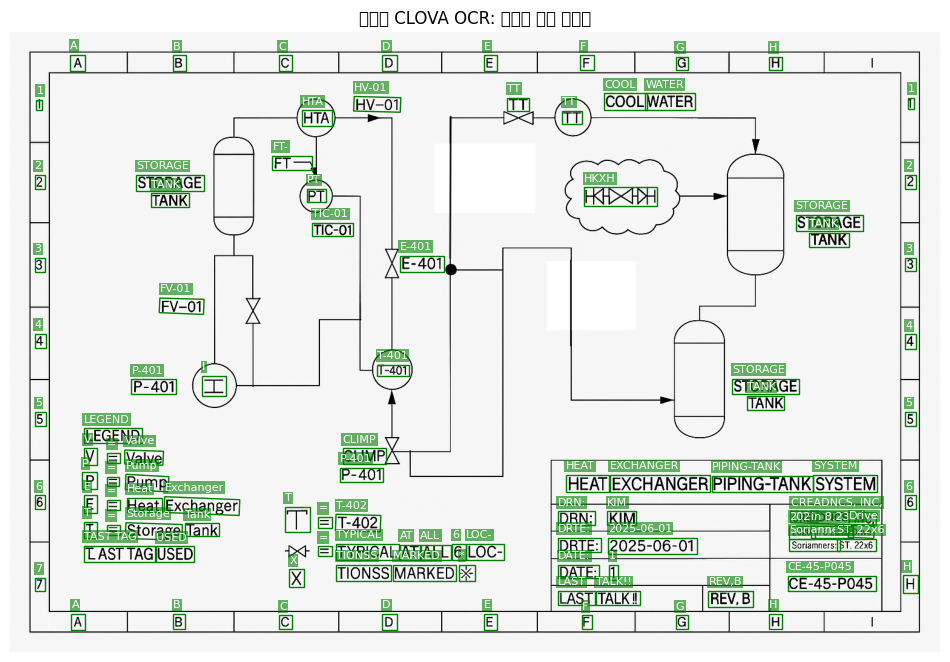

In [31]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def load_naver_ocr_boxes(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)

    lines = []
    try:
        for field in data["images"][0]["fields"]:
            text = field["inferText"]
            vertices = field["boundingPoly"]["vertices"]
            # 꼭짓점이 모두 있는 경우만 추가
            if len(vertices) == 4:
                box = [(v["x"], v["y"]) for v in vertices]
                lines.append((text, box))
    except KeyError as e:
        print("❌ 네이버 OCR JSON 구조 오류:", e)

    return lines

def draw_naver_ocr_boxes(image_path, lines):
    img = Image.open(image_path)
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img)

    for text, box in lines:
        poly = patches.Polygon(box, closed=True, fill=False, edgecolor='green', linewidth=1)
        ax.add_patch(poly)
        ax.text(box[0][0], box[0][1] - 10, text, fontsize=8, color='white',
                bbox=dict(facecolor='green', edgecolor='none', alpha=0.6, pad=1))

    plt.axis('off')
    plt.title("네이버 CLOVA OCR: 텍스트 위치 시각화")
    plt.show()

# 사용 예
image_path = "org2.png"
naver_json_path = "naver_result/org2.json"

ocr_lines = load_naver_ocr_boxes(naver_json_path)
draw_naver_ocr_boxes(image_path, ocr_lines)


In [20]:
import json

def convert_ocr_field(field):
    vertices = field["boundingPoly"]["vertices"]
    x_min = min(v["x"] for v in vertices)
    x_max = max(v["x"] for v in vertices)
    y_min = min(v["y"] for v in vertices)
    y_max = max(v["y"] for v in vertices)

    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    return {
        "id": field["inferText"],
        "label": field["inferText"],
        "position": {
            "x": center_x,
            "y": center_y,
            "width": width,
            "height": height
        },
        "type": "label",
        "source": "ocr"
    }

def convert_model_prediction(pred):
    return {
        "id": f"{pred['class']}@{int(pred['x'])}x{int(pred['y'])}",
        "label": pred["class"],
        "position": {
            "x": pred["x"],
            "y": pred["y"],
            "width": pred["width"],
            "height": pred["height"]
        },
        "type": pred["class"].lower().replace(" ", "_"),  # 예: "Gate Valve" → "gate_valve"
        "source": "model"
    }

def convert_json(input_path, output_path):
    with open(input_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    ocr_fields = data["images"][0]["fields"]
    model_preds = data.get("model_1_predictions", {}).get("predictions", [])

    unified_elements = [convert_ocr_field(f) for f in ocr_fields]
    unified_elements += [convert_model_prediction(p) for p in model_preds]

    result = {
        "version": data["version"],
        "elements": unified_elements
    }

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(result, f, indent=2)

    print(f"✅ 변환 완료: {output_path}")

# 예시 사용 방법
if __name__ == "__main__":
    convert_json("naver_result/.json", "naver_new.json")


✅ 변환 완료: naver_new.json


In [32]:
import json

def convert_ocr_field(field):
    vertices = field["boundingPoly"]["vertices"]
    x_min = min(v["x"] for v in vertices)
    x_max = max(v["x"] for v in vertices)
    y_min = min(v["y"] for v in vertices)
    y_max = max(v["y"] for v in vertices)

    center_x = (x_min + x_max) / 2
    center_y = (y_min + y_max) / 2
    width = x_max - x_min
    height = y_max - y_min

    return {
        "id": field["inferText"],
        "label": field["inferText"],
        "position": {
            "x": center_x,
            "y": center_y,
            "width": width,
            "height": height
        },
        "type": "label",
        "source": "ocr"
    }

def convert_model_prediction(pred):
    return {
        "id": f"{pred['class']}@{int(pred['x'])}x{int(pred['y'])}",
        "label": pred["class"],
        "position": {
            "x": pred["x"],
            "y": pred["y"],
            "width": pred["width"],
            "height": pred["height"]
        },
        "type": pred["class"].lower().replace(" ", "_"),
        "source": "model"
    }

def merge_ocr_and_model(ocr_path, model_path, output_path, version="merged"):
    with open(ocr_path, "r", encoding="utf-8") as f:
        ocr_data = json.load(f)

    with open(model_path, "r", encoding="utf-8") as f:
        model_data = json.load(f)

    # 추출 위치 수정: model["predictions"] → model["model"]["predictions"]
    ocr_fields = ocr_data["images"][0]["fields"]
    model_preds = model_data[0]["model"]["predictions"]

    unified_elements = [convert_ocr_field(f) for f in ocr_fields]
    unified_elements += [convert_model_prediction(p) for p in model_preds]

    output_json = {
        "version": version,
        "elements": unified_elements
    }

    with open(output_path, "w", encoding="utf-8") as f:
        json.dump(output_json, f, indent=2)

    print(f"✅ 병합 완료: {output_path}")

# 사용 예시
if __name__ == "__main__":
    merge_ocr_and_model(
        ocr_path="naver_result/org2.json",
        model_path="org2.json",
        output_path="standardized_elements_org2.json",
        version="v1"
    )


✅ 병합 완료: standardized_elements_org2.json
